In [ ]:
def get_s1_map(aoi_file, start, end, pol, mode, res, scale, crs, bands):
    """
        Arguments: lon=longitude, lat = latitude, ismn_idx = ismn_id, start=start date, end= end date, pol=polarizaion(VV, VH, [VV, VH, HV,...], mode= [IW, SW], res=resolution[10,20,30], red=reducer['first, mean, median'], scale=scale for reducer, crs=crs for reducer, must be same as for lat/lon
        Get Sentinel 1 GRD Time Series for lat/lon with Metadata as GeopandasGeoDataFrame
        """
    
    def add_ndvi(image, dateoffset = 15):
        """
        Arguments: Filter S2 TOA Collection to roi, mask cloudy pixels, calculate NDVI values, Make mosaic from +- 15 days from s1 image
        """
        def maskS2clouds(image):
            qa = image.select('QA60')
            #Bits 10 and 11 are clouds and cirrus, respectively.
            cloudBitMask = 1 << 10
            cirrusBitMask = 1 << 11
            #Both flags should be set to zero, indicating clear conditions.
            mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
            return image.updateMask(mask).divide(10000)

        def NDVI(image):
            ndvi = image.normalizedDifference(['nir','red']).rename('NDVI') #(first − second) / (first + second)
            return image.addBands(ndvi)
        
        # Sentinel 2 image collection with corresponding named bands
        bandNamesOut_s2 = ['Aerosols','blue','green','red','red edge 1','red edge 2','red edge 3','nir','red edge 4','water vapor','cirrus','swir1','swir2','QA60']
        bandNamesS2 = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12','QA60']
        
        s2_1c = ee.ImageCollection('COPERNICUS/S2').select(bandNamesS2,bandNamesOut_s2)
        s2_1c = s2_1c.filterDate(ee.Date(image.date().advance(-dateoffset,'days')), ee.Date(image.date().advance(+dateoffset,'days'))).filterBounds(image.geometry()).map(maskS2clouds).map(NDVI)
        
        ndvi = ee.Image(s2_1c.qualityMosaic('NDVI').select('NDVI'))
        
        return image.addBands(ndvi)
        
    #import modules
    import ee
    import geopandas as gpd
    from datetime import datetime
    from shapely.geometry import Point
    import json
    import time
    from IPython.display import clear_output
    from irrigation_detection import get_ERA5_ts
    # Authenticate Google Earth Engine
    try:
        ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com'
                      )  # High Volume Endpoint
    except:
        # Trigger the authentication flow
        ee.Authenticate()
        # Initialize the library
        ee.Initialize()

        
    aoi = gpd.read_file(aoi_file)
    
    # Create Geometry (Longitude/Latitude)
    aoi_fc = ee.FeatureCollection(aoi.to_json())
    #aoi_geometry = aoi_fc.geometry()
    aoi_geometry = ee.Geometry.Polygon(json.loads(aoi.to_json())['features'][0]['geometry']['coordinates'])
    #aoi_geometry = ee.Geometry.Polygon(aoi_geometry.getInfo())
    #aoi_geometry = ee.Geometry.Polygon()
    
    

    # Sentinel 1 Collection
    # Filter Collection by Location
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(ee.FeatureCollection(aoi_geometry))
    # Filter by Date
    sentinel1 = sentinel1.filterDate(start, end)
    # Filter by Polarization
    sentinel1 = sentinel1.filter(
        ee.Filter.listContains('transmitterReceiverPolarisation', pol))
    # Filter by Swath Mode
    sentinel1 = sentinel1.filter(ee.Filter.eq('instrumentMode', mode))
    # Filter by Resolution
    sentinel1 = sentinel1.filter(ee.Filter.eq('resolution_meters', res))
    
    sentinel1 = sentinel1.map(add_ndvi)
    sentinel1 = sentinel1.map(lambda x: x.clip(aoi_geometry))
    
    count = sentinel1.size().getInfo()
    names = sentinel1.aggregate_array('system:index').getInfo()
    platform = sentinel1.aggregate_array('platform_number').getInfo()
    orbit = sentinel1.aggregate_array('orbitProperties_pass').getInfo()
    collection = sentinel1.toList(count)
    
    for i in range(count):
        name = names[i] + '_' + orbit[i] + '_' + platform[i]
        for band in bands:
            image = ee.Image(collection.get(i)).select(band)
            task = ee.batch.Export.image.toDrive(image=image,
                     description = name + '_' + band,
                     folder='export_s1_map',
                     scale = scale,
                     crs = crs,
                    )
            task.start()
            print(f'Download {i}[{band}] / {count}')
    
    centroid = aoi_geometry.centroid().getInfo()['coordinates']
    return centroid

In [ ]:
centroid = get_s1_map(
    aoi_file = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/uni_gi_field_1.geojson',
    start = '2020-01-01',
    end = '2021-12-31', 
    pol = 'VV',
    mode = 'IW',
    res = 10,
    crs = 'EPSG:4326',
    scale = 10,
    bands = ['VV','VH', 'angle', 'NDVI']
    )

In [ ]:
from irrigation_detection import get_ERA5_ts

In [ ]:
gdf = get_ERA5_ts(
    lon = centroid[0], 
    lat = centroid[1], 
    ismn_idx = 'Feld 1', 
    start = '2020-01-01', 
    end = '2021-12-31', 
    red = 'first', 
    scale = 100, 
    crs = 'EPSG:4326', 
    idx_name = 'location')

gdf.to_file(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/uni_gi_field_1-era5.geojson', driver='GeoJSON')

In [1]:
import glob
import xarray as xr
import rioxarray as rio
from datetime import datetime
import pandas as pd
files = glob.glob(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/export_s1_map/*.tif')


def preprocess_get_s1_map(da):
    from datetime import datetime
    da = da.drop('spatial_ref').sel(band=1).drop('band')
    filename = da.encoding["source"]
    filename = filename.split('export_s1_map')[-1][1:]
    variable = filename.split('_')[-1].split('.')[0]
    date = datetime.strptime(filename.split('_')[4], '%Y%m%dT%H%M%S')
    da['time'] = date
    da = da.set_coords('time').expand_dims('time')
    da['orbit'] = filename.split('_')[-3]
    da['platform'] = filename.split('_')[-2]
    if variable == 'angle':
        da = da.rename({'band_data' : 'angle'})
    elif variable == 'NDVI':
        da = da.rename({'band_data' : 'NDVI'})
    elif variable == 'VV':
        da = da.rename({'band_data' : 'VV'})
    elif variable == 'VH':
        da = da.rename({'band_data' : 'VH'})
    else:
        print('Error')
        
    return da
                                      
data_xr = xr.open_mfdataset(files, engine='rasterio', preprocess=preprocess_get_s1_map)
data_pd = data_xr.to_dataframe()


In [2]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load pre trained model
cnn_basic_model = load_model(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm')

In [3]:
# One-Hot Encoding
df_predict = pd.get_dummies(data = data_pd, columns=['platform', 'orbit'])
df_predict['day_of_year'] = df_predict.index.get_level_values("time")
df_predict['day_of_year'] = df_predict.day_of_year.dt.day_of_year

In [4]:
#Normalization
scaler = MinMaxScaler(feature_range=(0, 1), copy = False)
df_predict[['NDVI', 'VV', 'VH', 'angle', 'platform_A', 'platform_B', 'orbit_ASCENDING','orbit_DESCENDING','day_of_year']] = scaler.fit_transform(X = df_predict[['NDVI', 'VV', 'VH', 'angle', 'platform_A', 'platform_B', 'orbit_ASCENDING','orbit_DESCENDING','day_of_year']])

In [5]:
df_predict.insert(0, 'day_of_year', df_predict.pop('day_of_year'))
df_predict.insert(1, 'VV', df_predict.pop('VV'))
df_predict.insert(2, 'VH', df_predict.pop('VH'))
df_predict.insert(3, 'angle', df_predict.pop('angle'))
df_predict.insert(4, 'platform_A', df_predict.pop('platform_A'))
df_predict.insert(5, 'platform_B', df_predict.pop('platform_B'))
df_predict.insert(6, 'orbit_ASCENDING', df_predict.pop('orbit_ASCENDING'))
df_predict.insert(7, 'orbit_DESCENDING', df_predict.pop('orbit_DESCENDING'))
df_predict.insert(8, 'NDVI', df_predict.pop('NDVI'))

In [6]:
predict_ssm_scale = cnn_basic_model.predict(df_predict[['day_of_year', 'VV', 'VH', 'angle','platform_A', 'platform_B',
            'orbit_ASCENDING', 'orbit_DESCENDING', 'NDVI']])
data_pd['ssm_scale'] = predict_ssm_scale
data_xr_1 = data_pd.to_xarray()

In [8]:
data_pd.to_csv(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/uni_gi_field_1.csv')

In [ ]:
import hvplot.xarray as hvplot

In [ ]:
data_xr_1.sel(x=8.501, y=49.938, method='nearest').ssm_scale.hvplot.scatter(width=1000)

In [ ]:
data_xr_1.sel(x=slice(8.502,8.503), y=slice(49.94,49.939)).ssm_scale.hvplot(
    groupby="time",  # adds a widget for time
    clim=(0, .5),  # sets colormap limits
    widget_type="scrubber",
    widget_location="bottom",
    #rasterize=True
)

In [ ]:
import rioxarray
import geojson

In [ ]:
geometry = ''' {"type": "Polygon",

                "coordinates": [
          [
            [
              8.498547077178955,
              49.94053923030635
            ],
            [
              8.497855067253113,
              49.93982802154236
            ],
            [
              8.500231504440308,
              49.93933085966698
            ],
            [
              8.500558733940125,
              49.94014910252704
            ],
            [
              8.498547077178955,
              49.94053923030635
            ]
          ]
        ]}'''

cropping_geometries = [geojson.loads(geometry)]
data_xr_1 = data_xr_1.rio.write_crs('EPSG:4326')
cropped = data_xr_1.rio.clip(geometries=cropping_geometries, crs='EPSG:4326')

In [ ]:
cropped

In [ ]:
data_xr_1.ssm_scale.hvplot(
    groupby="time",  # adds a widget for time
    clim=(0, .5),  # sets colormap limits
    widget_type="scrubber",
    widget_location="bottom",
    #rasterize=True
)


In [ ]:
        
    
    #desc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    #senA_desc = desc.filter(ee.Filter.eq('platform_number', 'A')).map(lambda x: x.clip(aoi_geometry))
    #senB_desc = desc.filter(ee.Filter.eq('platform_number', 'B')).map(lambda x: x.clip(aoi_geometry))
    
    #asc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    #senA_asc = asc.filter(ee.Filter.eq('platform_number', 'A')).map(lambda x: x.clip(aoi_geometry))
    #senB_asc = asc.filter(ee.Filter.eq('platform_number', 'B')).map(lambda x: x.clip(aoi_geometry))
    
    #count_desc_A = senA_desc.size().getInfo()
    #count_desc_B = senB_desc.size().getInfo()
    #count_asc_A = senA_asc.size().getInfo()
    #count_asc_B = senB_asc.size().getInfo()

    #print(f'count_desc_A: {count_desc_A},count_desc_B: {count_desc_B},count_asc_A: {count_asc_A}, count_asc_B: {count_asc_B}  ')
    #c=0
    #for collection, count, collection_name in zip([senA_desc, senB_desc, senA_asc, senB_asc], [count_desc_A, count_desc_B, count_asc_A, count_asc_B],['senA_desc', 'senB_desc', 'senA_asc', 'senB_asc']):
    #    names = collection.aggregate_array('system:index').getInfo()
    #    collection = collection.toList(count)
    #
    #   for i in list(range(count))[::2]:
    # #       if c >= 0:
    #            name1 = names[i]
    #            name2 = names[i+1]
    #            image1 = ee.Image(collection.get(i)).select(bands[0])
    #            image2 = ee.Image(collection.get(i)).select(bands[1])
    #            image3 = ee.Image(collection.get(i+1)).select(bands[0])
    #            image4 = ee.Image(collection.get(i+1)).select(bands[1])
    #            task1 = ee.batch.Export.image.toDrive(image=image1,
    #                                                 description = name1 + '_' + bands[0] + '_' + collection_name,
    #                                                 #region=aoi_geometry,
    #                                                 folder='idm_gee_export',
    #                                                 scale = scale,
     #                                                crs = crs,
    #                                                )
    #            task2 = ee.batch.Export.image.toDrive(image=image2,
    #                                 description = name1 + '_' + bands[1] + '_' + collection_name,
    #                                 #region=aoi_geometry,
#                                 folder='idm_gee_export',
#                                 scale = scale,
#                                 crs = crs,
#                                )



#            task3 = ee.batch.Export.image.toDrive(image=image3,
#                                                 description = name2 + '_' + bands[0] + '_' + collection_name,
#                                                 folder='idm_gee_export',
#                                                 scale = scale,
#                                                 crs = crs,
#                                                )
#            task4 = ee.batch.Export.image.toDrive(image=image4,
#                                 description = name2 + '_' + bands[1] + '_' + collection_name,
#                                 folder='idm_gee_export',
#                                 scale = scale,
#                                 crs = crs,
#                                )

#            task1.start()
#            task2.start()
#            task3.start()
#            task4.start()
#            c += 4
#        else:
#            c += 4
#        #while task1.active() or task2.active() or task3.active() or task4.active():
#        #    #print('Waiting on (id: {}).'.format(task1.id) , 'Waiting on (id: {}).'.format(task2.id),'\n', 'Waiting on (id: {}).'.format(task3.id), 'Waiting on (id: {}).'.format(task4.id))
#        #    print(f'Download {i} / {count}')
#        #    time.sleep(30)

   

Saisonale RGB Composite 

C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\USER\Anaconda3\envs\irrigation_detection\lib\site-packages\sklearn\preprocessing\_data.py:4

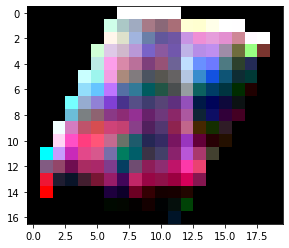

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1), copy = False)

R = data_xr.VV.sel(time = slice('2020-06-01', '2020-07-01')).mean('time')
G = data_xr.VV.sel(time = slice('2020-07-01', '2020-08-01')).mean('time')
B = data_xr.VV.sel(time = slice('2020-08-01', '2020-09-01')).mean('time')

R = scaler.fit_transform(R)
G = scaler.fit_transform(G)
B = scaler.fit_transform(B)

rgb = np.dstack((R,G,B)) 

plt.figure()
plt.imshow(rgb)
plt.show()